## Exploratory Analysis, using Named-Entity Recognition to Classify Police Officers

##### Jonathan Juarez
##### Date 2/13/2024

To understand how police officers are being disciplined when allegations are found to be sustained, Named-Entity Recognition, or NER models, can be utilized to identify and extract relevant entities from text, such as types of disciplinary actions.

In [1]:
import os
import re
import random
import pandas as pd

I'm stealing both Matt's and Fede's cleaning of the text as it might be important to follow similar cleaning structures. We should use common cleaning functions by storing them in a .py file later on.

In [2]:
PATH = "/Users/jonathanjuarez/Documents/Advanced ML/NLP-Police-Complaints/text_files"
CHARS_TO_REMOVE = ["\n"]
REGEX_PATTERNS = [
    r"civilian office of police accountability\s+",
    r"log\s*\#\s*\d+",
    r"-\s*\d+\s*\d+",
    r"summary report of investigation\s+",
    r"i.\s+executive\s+summary",
    r"_+",
    r"\s*date of incident:\s*\w+\s+\d+,\s+\d+",
    r"\s*time of incident:\s*\d+:\d+\w+",
    r"\s*location of incident:\s*\d+\w+\s*\w+",
    r"\s*date of copa notification:\s*\w+\s+\d+,\s+\d+",
    r"\s*time of copa notification:\s*\d+:\d+\w+",
    r"applicable rules and laws|"
    r"conclusion|"
    r"digital evidence|"
    r"documentary evidence|"
    r"legal standard|",
]


I'm using Fede's TextParser to format the text and turn them into lists of strings.

In [3]:
class TextParser:
    CHARS_TO_REMOVE = CHARS_TO_REMOVE
    REGEX_PATTERNS = REGEX_PATTERNS

    def __init__(self, path):
        self.path = path

    def txt_to_list(self, filename):
        """
        Add each line of a text file to a list
        """

        file_path = os.path.join(self.path, filename)
        lines = []
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip().split()
                lines.append(line)

        return lines

    def file_to_string(self, filename):
        """
        Add each line of a text file to a string
        """
        text = ""
        file_path = os.path.join(self.path, filename)
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                for char in self.CHARS_TO_REMOVE:
                    line = line.replace(char, "")
                text += line

        text = text.strip()
        #text = text.lower() #NET requires words to be capitilized for proper usage
        text = re.sub(r"\s+", " ", text)

        # Remove REGEX patterns
        for pattern in self.REGEX_PATTERNS:
            text = re.sub(pattern, "", text, flags=re.IGNORECASE)
        return text

text_parser = TextParser(PATH)


In [29]:
# Create a list of the txt files for processing NER later
cases = os.listdir(PATH)
cases = [case for case in cases if case.endswith(".txt")]
cases = random.sample(cases, 10)

I'll be using the NLTK library for the NER model. There are packages in the NLTK that must be downloaded in order to run the code below.

In [36]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk

nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Error loading maxent_ne_chunker: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading words: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:1000)>


False

The [ne_chunk](https://www.nltk.org/api/nltk.chunk.html) function takes the part-of-speech tagged words and performs NER. It groups consecutive tokens into chunks and labels them based on their entity type (e.g., PERSON, ORGANIZATION, LOCATION). The extract_entities function then iterates through the resulting tree structure and identifies entities. These entities are returned as list of tuples, where each tuple contains the identified entity and its corresponding entity type.

In [6]:
def extract_entities(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    tree = ne_chunk(pos_tags)

    entities = []
    for subtree in tree:
        if isinstance(subtree, nltk.Tree):
            entity = " ".join([word for word, tag in subtree.leaves()])
            entity_type = subtree.label()
            entities.append((entity, entity_type))
    
    return entities


In [7]:
for case in cases:
    case_text = text_parser.file_to_string(case)
    list_of_entities = extract_entities(case_text)

    # Print or store the information for each case
    print(f"Entities for Case:", case)
    for entity, entity_type in list_of_entities:
        print(f"Word: {entity}, POS Tag: {pos_tag([entity])[0][1]}, Entity Type: {entity_type}")

    # If we want to store the information in a different format do it here

Entities for Case: 2015-1083062.txt
Word: Incident, POS Tag: NN, Entity Type: GPE
Word: COPA, POS Tag: NN, Entity Type: ORGANIZATION
Word: COPA, POS Tag: NN, Entity Type: ORGANIZATION
Word: INVOLVED, POS Tag: NN, Entity Type: ORGANIZATION
Word: PARTIES, POS Tag: NN, Entity Type: ORGANIZATION
Word: Individual, POS Tag: JJ, Entity Type: GPE
Word: ALLEGATIONS, POS Tag: NN, Entity Type: ORGANIZATION
Word: District, POS Tag: NNP, Entity Type: GPE
Word: DOB, POS Tag: NN, Entity Type: ORGANIZATION
Word: OM, POS Tag: NN, Entity Type: ORGANIZATION
Word: COPA, POS Tag: NN, Entity Type: ORGANIZATION
Word: IPRA, POS Tag: NN, Entity Type: ORGANIZATION
Word: Chicago, POS Tag: NNP, Entity Type: ORGANIZATION
Word: IPRA, POS Tag: NN, Entity Type: ORGANIZATION
Word: COPA, POS Tag: NN, Entity Type: ORGANIZATION
Word: COPA, POS Tag: NN, Entity Type: ORGANIZATION
Word: General Orders, POS Tag: NNS, Entity Type: ORGANIZATION
Word: Special Orders, POS Tag: NNS, Entity Type: ORGANIZATION
Word: MIMI, POS Tag: 

We may want to focus only on named people in the cases and avoid printing or storing information for every word, so created a new function extract_persons for this specific purpose. 

In [37]:
def extract_persons(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    tree = ne_chunk(pos_tags)

    persons = []
    for subtree in tree:
        if isinstance(subtree, nltk.Tree) and subtree.label() == 'PERSON':
            persons.append(" ".join([word for word, tag in subtree.leaves()]))

    return persons

for case in cases:
    case_text = text_parser.file_to_string(case)
    list_of_persons = extract_persons(case_text)

    # Print or store the information for each case
    print(f"Persons in Case:", case)
    for person in list_of_persons:
        print(person)


Persons in Case: 2018-1092127.txt
Harlem
Officer
Officer
Officer
Officer
Star
Employee ID
Star
Employee ID
Hispanic III
Officer
Officer
Officer
Harlem Ave.
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Transmissions14
Beat
Officer
Officer
Officer
Officer
Officer
Officer
Sgt
Officer
Officer
Officer
Officer
Officer
Avery
Farm Mutual Automobile Insurance
People v. Coan
Order G03
Officer
Officer
Officer
Officer
Officer
Further
Officer
Officer
Officer
Officer
Officer
Officer
Award Type Count Emblem
Penalty
Approved
Angela Hearts
Persons in Case: 2020-0004231.txt
Involved Officer
Star
Employee ID
Rank
Lester Tojong
Star
Employee ID
Rank
Star
Employee ID
Rank Sergeant
Star
Lester Tojong
Lester Tojong
Star
Star
Victor Montes
Lester Tojong
Upon
Sergeant Lieblick
Sergeant Lieblick
Officer Montes
Officer Montes
Se

To better determine people extraction, I updated the function to return a set of unique person entities found and their counts in the text, and modified the function to allow different entity extractions, such as "PERSON", "LOCATION", etc.

In [31]:
from nltk.tree import Tree

In [41]:
def extract_entity(text, entity_type, counts=False):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    tree = ne_chunk(pos_tags)

    entities = set()  # Use a set to store unique entities
    entity_counts = {}  # Initialize a dictionary to count occurrences of each entity

    for subtree in tree:
        if isinstance(subtree, Tree) and subtree.label() == entity_type:
            entity_name = " ".join([word for word, tag in subtree.leaves()])
            entities.add(entity_name)  # Add to set to ensure uniqueness
            
            # Count occurrences if counts is True
            if counts:
                if entity_name in entity_counts:
                    entity_counts[entity_name] += 1
                else:
                    entity_counts[entity_name] = 1

    if counts:
        return entity_counts
    else:
        return list(entities)

Here I aim to analyze what entities labeled as "PERSON" are extracted.

In [48]:
all_unique_entities = set()
all_entity_counts = {} 

for case in cases:
    case_text = text_parser.file_to_string(case)
    unique_entities = extract_entity(case_text, 'PERSON')  # Extract unique entities from this case
    # Update the overall set with new entities from this case
    all_unique_entities.update(unique_entities)

    entity_counts = extract_entity(case_text, 'PERSON', counts=True)  # Extract entity counts from this case
    # Update the overall dictionary with counts from this case
    for entity, count in entity_counts.items():
        if entity in all_entity_counts:
            all_entity_counts[entity] += count  # Add to existing count
        else:
            all_entity_counts[entity] = count  # Initialize count for new entities

In [55]:
print("Counts of Each Person Name:")
for person, count in sorted(all_entity_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{person}: {count}")

Counts of Each Person Name:
Officer: 66
Officer A: 29
Jakupovic: 28
Officer B: 28
Officer Haleem: 24
Robbery Victim: 23
Roben: 21
Officer Jakupovic: 19
Joseph Shanahan: 18
Mahmoud Haleem: 17
Haleem: 15
Star: 14
Officer C: 14
Brian Glim: 13
Officer Roben: 11
Mr.: 11
Employee ID: 10
B: 10
Officer E: 10
Santisuk: 9
Shanahan: 7
Glim: 7
Officer D: 7
Rank: 6
Race: 6
Inv: 6
Frances Lee: 6
Officer Hunt: 6
Officer F: 6
Penalty: 5
Award: 5
Gender: 5
Male: 5
Officer Glim: 5
Sergeant Sabatino: 5
Subjec: 5
Beat XXXXX: 5
Beat: 4
Sgt: 4
Farm Mutual Automobile Insurance: 4
Lester Tojong: 4
Jasmin Jakupovic: 4
Chicago: 4
Officer Santisuk: 4
Officer Joseph Shanahan: 4
Illinois State: 4
Officer Shanahan: 4
Drexel Avenue: 4
Martin Luther: 4
Subject1: 4
Assault: 4
Avery: 3
People v. Coan: 3
Involved Officer: 3
Sergeant Lieblick: 3
Sergeant Michael Trobiani: 3
Trobiani: 3
Schmit: 3
Pakorn Santisuk: 3
Matthew Roben: 3
Levine: 3
Roscoe: 3
Steven Sabatino: 3
Firearm Owners: 3
James Hunt: 3
Hunt: 3
Battery Repo

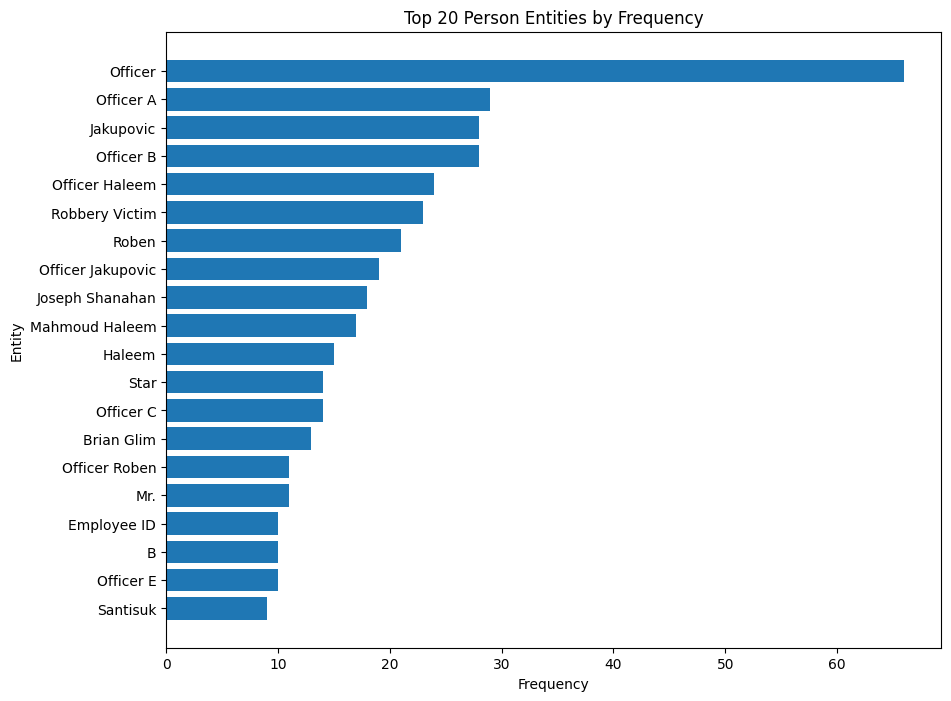

In [51]:
import matplotlib.pyplot as plt

# Prepare data for plotting
names = list(all_entity_counts.keys())
counts = list(all_entity_counts.values())

# Sort data by counts
sorted_indices = sorted(range(len(counts)), key=lambda k: counts[k], reverse=True)
sorted_names = [names[i] for i in sorted_indices]
sorted_counts = [counts[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(sorted_names[:20], sorted_counts[:20])  # Display top 20 entities for readability
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.title('Top 20 Person Entities by Frequency')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest counts at the top
plt.show()

Top occurring person entitites appear to be fine, however those that are low in frequency are being misclassified. I suspect this is due to NLTKs relyance on capitalization for classification. I attempt to see what happens if all text is lower-cased below.

In [56]:
all_unique_entities = set()
all_entity_counts = {} 

for case in cases:
    case_text = text_parser.file_to_string(case)
    case_text = case_text.lower()  # Convert the entire text to lowercase
    unique_entities = extract_entity(case_text, 'PERSON')  # Extract unique entities from this case
    # Update the overall set with new entities from this case
    all_unique_entities.update(unique_entities)

    entity_counts = extract_entity(case_text, 'PERSON', counts=True)  # Extract entity counts from this case
    # Update the overall dictionary with counts from this case
    for entity, count in entity_counts.items():
        if entity in all_entity_counts:
            all_entity_counts[entity] += count  # Add to existing count
        else:
            all_entity_counts[entity] = count  # Initialize count for new entities

In [57]:
print("Counts of Each Person Name, with lower cased text:")
for person, count in sorted(all_entity_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{person}: {count}")

Counts of Each Person Name, with lower cased text:
mr.: 3


This shows capitilizing is a parameter to consider when conducting NER with NLTK. The out of the box NER model using NLTK doesn't appear to be that great in capturing relevant people and consideres locations and other random entitites as a "Person". We will try [SpaCy](https://spacy.io/api), which has a more accurate NER model compared to NLTK and we will fine-tune parameters if needed.

In [59]:
import spacy

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

def extract_entity_spacy(text, entity_type, counts=False):
    doc = nlp(text)
    entities = set()
    entity_counts = {}

    for ent in doc.ents:
        if ent.label_ == entity_type:
            entity_name = ent.text
            entities.add(entity_name)

            if counts:
                entity_counts[entity_name] = entity_counts.get(entity_name, 0) + 1

    return entity_counts if counts else list(entities)


In [64]:
all_persons = set()
all_person_counts = {}

for case in cases:
    case_text = text_parser.file_to_string(case)  # Assuming this function reads case file content
    case_text = case_text.lower()
    persons = extract_entity_spacy(case_text, 'PERSON')
    person_counts = extract_entity_spacy(case_text, 'PERSON', counts=True)
    
    # Update the set with unique person names
    all_persons.update(persons)
    
    # Update the dictionary with counts
    for person, count in person_counts.items():
        all_person_counts[person] = all_person_counts.get(person, 0) + count



In [65]:
print("Person Entity Counts:")
for person, count in sorted(all_person_counts.items(), key=lambda item: item[1], reverse=True):
    print(f"{person}: {count}")


Person Entity Counts:
joseph shanahan: 19
mahmoud haleem: 17
brian glim: 11
steven sabatino: 9
frances lee: 9
trobiani: 8
jakupovic: 8
robbery victim: 6
michael trobiani: 5
matthew roben: 5
a. officer: 5
jason lieblick: 4
avery v. state farm mutual automobile insurance co.: 3
people v. coan: 3
jasmin: 3
james hunt: 3
investigation1 a. interviews: 2
evidence1: 2
lieblick: 2
matthew haynam: 2
joe holt: 2
jonathan carroll: 2
bogdan kalynyuk: 2
jasmin jakupovic: 2
aaron levine: 2
levine: 2
brian: 2
mahmoud: 2
joseph shanahan 1: 2
people v. arnold: 2
jose: 2
s. martin luther: 2
offi cer: 2
yelling12: 1
b.  copa: 1
c.  an: 1
report19: 1
i. complimentary: 1
angela hearts: 1
lester tojong: 1
al state: 1
-(2: 1
steffany hreno: 1
report1: 1
evidence4: 1
appendix b. 13 att: 1
michael trobiani i. complimentary: 1
awa rd: 1
b. sergeant greg: 1
w. taylor street: 1
ma le: 1
santisuk7: 1
aroun d: 1
jakupovic11: 1
levine16: 1
video19: 1
c.  : 1
jakupovic27: 1
ed officer: 1
roben i. complimentary: 1
art

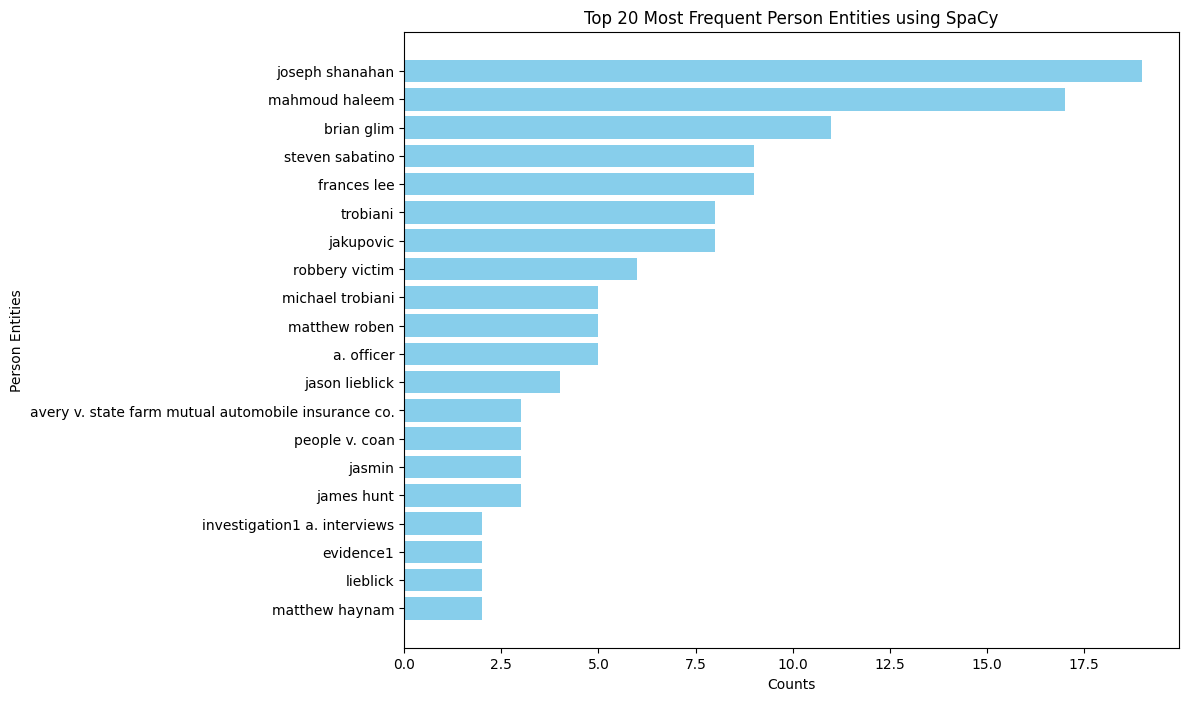

In [66]:
top_persons = sorted(all_person_counts.items(), key=lambda item: item[1], reverse=True)[:20]
names, counts = zip(*top_persons)

# Create the plot
plt.figure(figsize=(10, 8))
plt.barh(names, counts, color='skyblue')
plt.xlabel('Counts')
plt.ylabel('Person Entities')
plt.title('Top 20 Most Frequent Person Entities using SpaCy')
plt.gca().invert_yaxis()
plt.show()

Even when using lower cased words, SpaCy outperforms NLTK in correctly classifying individuals as "PERSON" for these 10 cases. Other entities that SpaCy can extract are as follows: 

In [67]:
nlp = spacy.load("en_core_web_sm")
print(nlp.get_pipe("ner").labels)

('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


We can consider adding extra entities for filtration, and also using the nlp.pipe method is significantly more efficient than calling nlp on each text individually. It processes texts as a stream and yields processed Doc objects, which is especially useful for large-scale data. We are using a small sized model [en_core_web_sm](https://spacy.io/models/en#en_core_web_sm) for proecessing efficiency, but can be changed for a larger NER model if we want potentially better results.

In [79]:
def extract_entities_spacy(texts, entity_types=None, model="en_core_web_sm", batch_size=1000):
    """
    Extracts entities from a list of texts using SpaCy and counts their occurrences.

    Parameters:
    texts (list of str): The texts from which to extract entities.
    entity_types (list of str or str, optional): The types of entities to extract (e.g., 'PERSON', 'ORG'). If None, all types are extracted.
    model (str, optional): The SpaCy model to use for entity extraction. Defaults to 'en_core_web_sm'.
    batch_size (int, optional): The number of texts to process at a time. Defaults to 1000.

    Returns:
    dict: A dictionary where keys are entities and values are their counts.
    """
    nlp = spacy.load(model)
    
    if isinstance(entity_types, str):
        entity_types = [entity_types]
    
    entities = {}

    for doc in nlp.pipe(texts, batch_size=batch_size):
        for ent in doc.ents:
            if entity_types is None or ent.label_ in entity_types:
                entity_counts[ent.text] = entity_counts.get(ent.text, 0) + 1

    return entities

In [80]:
texts = []
for case in cases:
    case_text = text_parser.file_to_string(case)
    texts.append(case_text)

entity_types = ['PERSON', 'ORG']  # Specify desired entity types, or None to extract all types

entity_counts = extract_entities_spacy(texts, entity_types)
for entity, count in entity_counts.items():
    print(f"{entity}: {count}")

Officer #: 1
Male: 9
White Involved: 2
Rules 2,: 6
Maltreated: 1
Department: 28
V. INVESTIGATION1 a. Interviews COP: 1
COP: 1
Officer #4: 1
the Original Case Incident Report: 2
Officer #8: 1
yelling12: 1
b.  COPA: 1
CPD: 44
Jeep: 2
c.  : 2
Sgt: 4
The Original Case Incident Report22: 1
RD #: 1
The Office of Emergency Management and Communications Event Query Report25: 1
Avery: 4
People v. Coan: 3
IL App: 3
ANALYSIS: 4
Sustained for Allegation: 1
Order G03: 1
COPA: 63
Allegation #1: 2
Not Sustained for Allegation #2: 1
Officer: 1
Allegation #2: 2
Exonerated for Allegation: 1
SUSTAINED ALLEGATIONS a. Officer: 1
Recognition - Physical Fitness 3 Attendance Recognition: 1
Angela Hearts: 1
Victor Montes: 4
Employee ID# , Date of Appointment: 2
Rank Police Officer: 2
DOB: 16
WWH Involved Officer: 1
Lester Tojong: 4
API Jason Lieblick: 1
Rank Sergeant of Police: 1
I. ALLEGATIONS Officer Allegation Finding Officer: 1
EXONERATED: 10
Jason Lieblick: 1
Sergeant Jason Lieblick: 2
EXONERATED EXONERAT

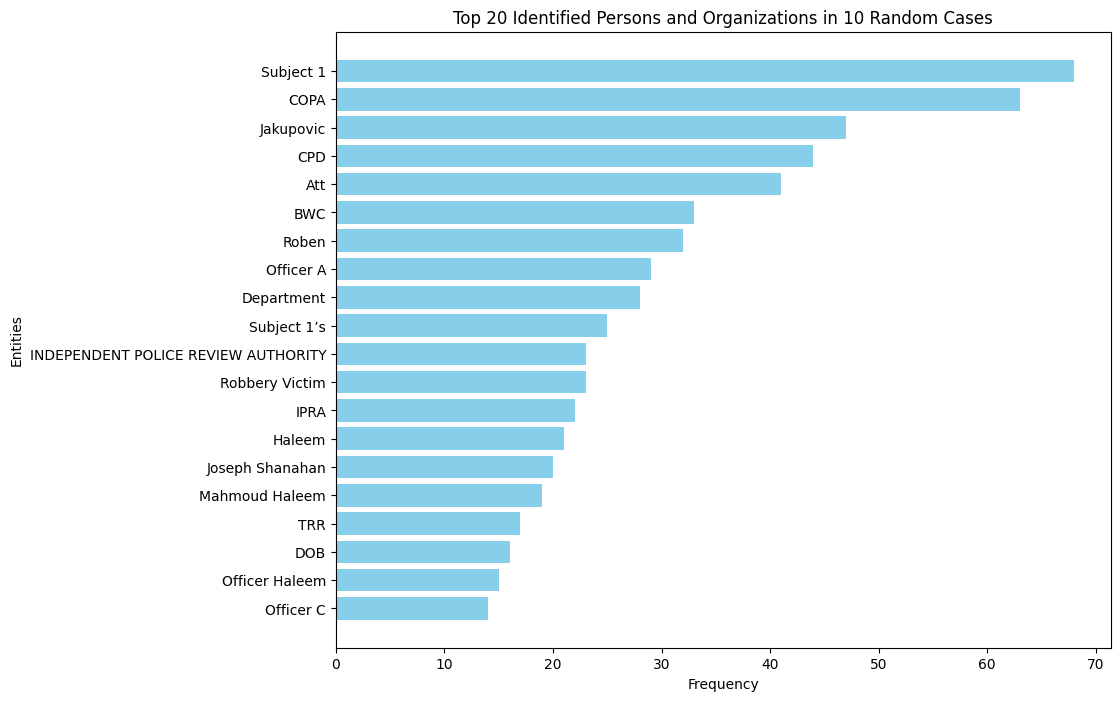

In [84]:
sorted_entity_counts = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)

top_n = sorted_entity_counts[:20]

entities, counts = zip(*top_n)  # Unzip the entity names and their counts

plt.figure(figsize=(10, 8))
plt.barh(entities, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Entities')
plt.title('Top 20 Identified Persons and Organizations in 10 Random Cases')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest counts at the top
plt.show()